<a href="https://colab.research.google.com/github/JSJeong-me/Uniinfo-Machine-Vision/blob/main/U0805/kaggle_cv_lec_05_0812-custom_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 소개  
이제 특성 추출을 위해 합성곱 레이어가 사용하는 레이어를 살펴보았으니, 스스로 신경망을 만들어보자!

In [2]:
# !cp /content/drive/MyDrive/archive.zip .

In [3]:
# !unzip archive.zip

# 간단하게부터 세련되게까지 
마지막 세 개의 레슨에서는, 합성곱 신경망이 필터링, 감지, 압축 세 과정을 통해 특성 추출을 하는 과정을 살펴보았다. 특성 추출을 한 번 하면 선의 형태와 대비 등 간단한 특징만 잡아낸다. 이는 대부분의 분류 문제를 해결하기에는 너무 간단하다. 대신, 합성곱 신경망은 특성 추출을 계속 반복하여 신경망이 깊게 학습할수록 더욱 '복잡하고 세련된' 특성을 감지하도록 한다.  
<figure>
<img src="https://i.imgur.com/VqmC1rm.png" alt="Features extracted from an image of a car, from simple to refined." width=800>
</figure>  

# 합성곱 블록
이 방법은 특성 추출을 하는 '합성곱 블록' 여러 개를 통과시키게 하여 구현 가능하다.  
<figure>
<img src="https://i.imgur.com/pr8VwCZ.png" width="400" alt="Extraction as a sequence of blocks.">
</figure>  
  
  이런 합성곱 블록은 'Conv2D'와 'MaxPool2D' 레이어의 스택(stack)이다.  
<figure>
<!-- <img src="./images/2-block-crp.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling."> -->
<img src="https://i.imgur.com/8D6IhEw.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling.">
</figure>  
  
  각 블록은 하나의 특성 추출 과정을 의미하고, 합성곱 신경망에서 이런 블록을 조합하면서 추출되는 특성을 분류 문제를 해결하기에 더욱 적합한 특성으로 재출력시킬 수 있다. 이렇듯 현대 합성곱 신경망의 깊은 구조가 압도적인 성능의 이유가 된다.

# 예시 - 합성곱 신경망 만들기  
복잡한 특성을 추출할 수 있는 깊은 합성곱 신경망을 구현하는 과정을 살펴보자 이 예시에서는, 케라스의 Sequential 모델을 만들어 Cars 데이터셋에 훈련시킬 것이다.  
## Step 1 - 데이터 불러오기  

In [4]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
# 시드 생성기
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [6]:
# matplotlib 사전 설정
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # 에러 메시지를 띄우지 않게 하여 출력창을 정리함

In [7]:
# 훈련, 검증 데이터셋 불러오기
ds_train_ = image_dataset_from_directory(
    './train',
    labels = 'inferred',
    label_mode = 'binary',
    image_size = [128, 128],
    interpolation='nearest',
    batch_size = 64,
    shuffle = True
)

Found 5117 files belonging to 2 classes.


In [8]:
type(ds_train_)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [9]:
ds_valid_ = image_dataset_from_directory(
    './valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

Found 5051 files belonging to 2 classes.


In [10]:
# 데이터 파이프라인
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (ds_train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
ds_valid = (ds_valid_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

## Step 2 - 모델 정의하기
아래는 우리가 사용할 모델의 모습니다.  
<figure>
<!-- <img src="./images/2-convmodel-1.png" width="200" alt="Diagram of a convolutional model."> -->
<img src="https://i.imgur.com/U1VdoDJ.png" width="250" alt="Diagram of a convolutional model.">
</figure>  
우리 모델은 베이스로 Conv2D와 MaxPool2D 레이어의 블럭이 3개, 헤드인 Dense 레이어들로 이루어진다. 이 구조를 파라미터만 잘 설정한다면 케라스의 Sequential 모델로 적을 수 있다.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
# model = keras.Sequential()
# model.summary()

블럭마다 필터의 크기는 증가한다 : 64, 128, 256. 이는 흔한 패턴이다. MaxPool2D 레이어가 특성 맵의 사이즈를 감소시키니, 그 개수를 증가시키는 것이다.

## Step 3 - 훈련  
이제 모델을 비용에 대해 최적화하여 이진 분류 문제에 걸맞게 훈련시키자.

In [13]:
model_layers= [
    
    # 첫 번째 합성곱 레이어
    layers.Conv2D(filters = 32, kernel_size=3, activation='relu', padding='same',
                 input_shape = [128,128,3]), # [높이, 너비, 컬러 채널(RGB)]로 입력값의 차원 정의
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    
    # 두 번째 합성곱 레이어
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    
    # 세 번째 합성곱 레이어
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # 분류자 헤드
    layers.Flatten(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=6, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=1, activation='sigmoid')
]

In [14]:
model = keras.Sequential(model_layers)

In [ ]:
model.summary()

In [16]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [ ]:
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 40
)

In [18]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

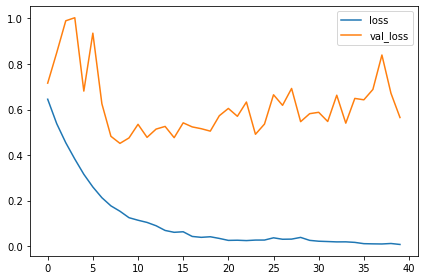

In [19]:
history_frame.loc[:, ['loss', 'val_loss']].plot()

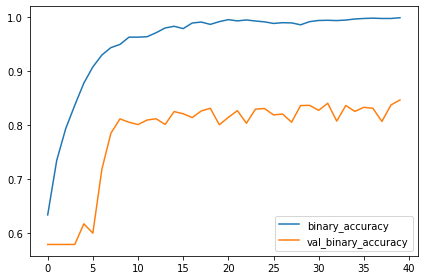

In [20]:
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [21]:
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(ds_valid, y_test, batch_size=128)
# print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(ds_valid[0])
# print("predictions shape:", predictions.shape)

In [22]:
type(ds_valid)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [23]:
ds_valid[0,128,128,3]

TypeError: ignored

이 모델은 첫 번째 레슨의 VGG16 모델보다 작다. 16개의 합성곱 레이어를 가진 VGG16에 비해 3개 밖에 없다. 그러나 데이터 셋을 어느 정도 잘 반영한다. 합성곱 레이어를 추가한다면 더욱 효과적일 것이다.

# 결론  
이 튜토리얼에서는 어떻게 여러 개의 합성곱 블록으로 이루어진 합성곱 신경망을 만드는지를 살펴보았다.